In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Check if extracted data folder exists
usingColab = 0
if usingColab:
  if(not os.path.exists('SYSC4415W23_A3_dataset')):

    # Download and extract the dataset if the zip file does not exist
    if (not os.path.isfile('SYSC4415W23_A3_dataset.zip')):
      !wget https://github.com/jrgreen7/SYSC4906/releases/download/Assignment3/SYSC4415W23_A3_dataset.zip
      !unzip SYSC4415W23_A3_dataset.zip

  datasetPath = r"SYSC4415W23_A3_dataset"

else:
  datasetPath = r"C:/Users/googl/Documents/ML/A3_Dataset/SYSC4415W23_A3_dataset"

In [3]:
train_labels = pd.read_csv(f'{datasetPath}/train/labels.csv')
train_features = pd.read_csv(f'{datasetPath}/train/extracted_features.csv')

train_features.set_index(keys='sample_id', inplace=True)
train_features.sort_values(by=['sample_id'], inplace=True)
train_labels.set_index(keys='sample_id', inplace=True)
train_labels.sort_values(by=['sample_id'], inplace=True)

print(f'Shape of original features: {train_features.shape}')

Shape of original features: (1621, 7047)


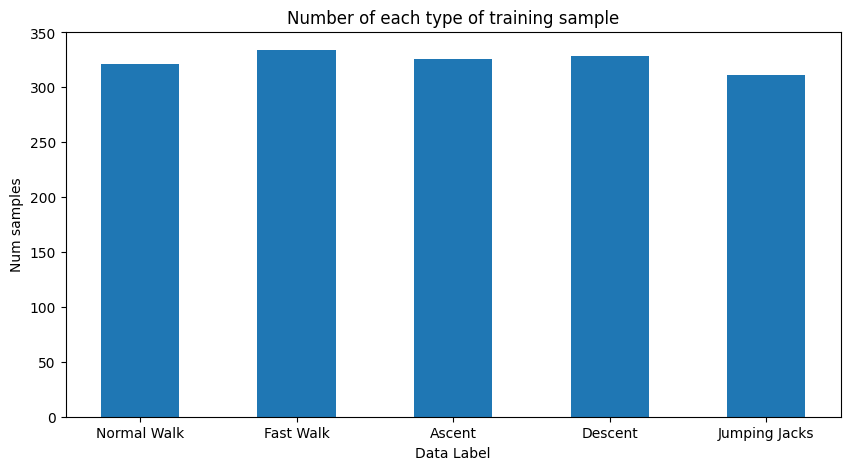

In [4]:
# Data visualization
counts = train_labels.value_counts(subset=['label'])
keys = ['Normal Walk', 'Fast Walk', 'Ascent', 'Descent', 'Jumping Jacks']
vals = [counts[0],counts[1], counts[2], counts[3], counts[4]]

fig = plt.figure(figsize=(10,5))
plt.bar(x=keys, height=vals, width=0.5)
plt.xlabel("Data Label")
plt.ylabel("Num samples")
plt.title("Number of each type of training sample")
plt.show()

# No class imbalance

### Feature Selection 
Using variance thresholding, dropping any features with NaN values and using univariate stats to determince the ***__top 50% of features__*** for classification to determine which features are useful.

In [5]:
# Remove features that have very low variance
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif

# Drop columns with very low variance
sel = VarianceThreshold(threshold=(0.95 * (1 - 0.95)))
sel.fit_transform(train_features)
cols = [column for column in train_features.columns 
          if column not in train_features.columns[sel.get_support()]]
train_selected = train_features.drop(columns=cols)
print(f'Shape after dropping columns with variance lower than .9525: {train_selected.shape}')

# Drop columns with nan values
toDrop = train_selected.columns[train_selected.isnull().any()].tolist()
train_selected.drop(toDrop, axis=1, inplace=True)
print(f'Number of reduced features from removing NaN values: {train_selected.shape}')

# # Find indexes of columns with correlation greater than 0.8
# corr_matrix = train_features.corr().abs()
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# to_drop = []

# to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
# train_features.drop(columns=to_drop, inplace=True)
# print(f'Number of features after removing columns with high correlation: {train_features.shape}')

# Using top 1750 features
numFeatures = 2000
nextSel = SelectKBest(score_func=f_classif, k=numFeatures)
nextSel.fit_transform(train_selected, train_labels['label'])
cols = [column for column in train_selected.columns 
          if column not in train_selected.columns[nextSel.get_support()]]
dataset = train_selected.drop(columns=cols)
print(f'Feature data shape after SelectKBest using f-value stats: {dataset.shape}')

# Free up memory for next tasks
del toDrop, cols, sel, nextSel


C:\Users\googl\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_variance_threshold.py:111: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)


Shape after dropping columns with variance lower than .9525: (1621, 5423)
Number of reduced features from removing NaN values: (1621, 5402)
Feature data shape after SelectKBest using f-value stats: (1621, 2000)


#### Data Loading and organization

In [30]:
# from torch.utils.data import DataLoader
batchSize = 32
tr_split = 1400 # ~80% of labelled data
te_split = 221  # ~10% of labelled data

dataset['label'] = train_labels['label']
dataset = dataset.sample(frac=1) # Shuffle rows before breaking into sets

trainSet = dataset.iloc[:tr_split] # Shape: 1300, 2701
testSet = dataset.iloc[tr_split:]  # Shape: 321, 2701

### Building model
**Hyperparameters**: 
- Learning rate: Using effective LR calculated from base LR using:
$$\eta_{eff} = \frac{B\eta_{base}}{256}$$
- Input size: 2700
- Output size: 5 (1 per class label)
- Hiddel layers: 1
- Nodes/hidden layer: 1800 (2/3 of input size, since input size > num samples)

In [ ]:
from sklearn.neural_network import MLPClassifier
import time
lr_base = 0.0001
maxIterations = 1500

lr = (batchSize*lr_base)/256
MLP = MLPClassifier((1000,), 'relu', solver='adam', learning_rate_init=lr, max_iter=maxIterations, batch_size=batchSize)
trainData = trainSet.iloc[:, :-1] # 1300, 1500
trainLabels = trainSet.iloc[:,-1] # 1300, 1

start = time.time()
MLP.fit(trainData.to_numpy(), trainLabels.to_numpy())
totalTime = time.time() - start
print(f'Training time: {round(totalTime, ndigits=2)} s')

In [ ]:
import autosklearn.classification
cls = autosklearn.classification.AutoSklearnClassifier()
trainData = trainSet.iloc[:, :-1] # 1300, 1500
trainLabels = trainSet.iloc[:,-1] # 1300, 1

start = time.time()
cls.fit(trainData, trainLabels)
totalTime = time.time() - start
print(f'Training time: {round(totalTime, ndigits=2)} s')

In [ ]:
losses = MLP.loss_curve_
valScores = MLP.validation_scores_
iterations = np.linspace(0, MLP.n_iter_, len(losses))

print(f'Number of iterations: {MLP.n_iter_}')
print(f'Best Val score: {MLP.best_validation_score_}')
figs, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(iterations, losses)
ax[0].set_title('Training losses'); ax[0].set_xlabel('Iteration'); ax[0].set_ylabel('Loss')
ax[1].plot(iterations, valScores)
ax[1].set_title('Training validation'); ax[1].set_xlabel('Iteration'); ax[1].set_ylabel('Score')

In [48]:
from sklearn.metrics import accuracy_score

testCols = testSet.columns
for col in trainSet.columns:
  if col not in testCols:
    testSet.drop(columns=col)

testData = testSet.iloc[:, :-1] # 321, 1500
testLabels = testSet.iloc[:,-1] # 321, 1

trainLabelsEx = MLP.predict(X=trainData) # output 1300, 1
testLabelsEx = MLP.predict(X=testData) # output 321, 1
testLabelsEx = pd.Series(data=testLabelsEx, index=testData.index)


tr_score = accuracy_score(trainLabels, trainLabelsEx)
te_score = accuracy_score(testLabels, testLabelsEx)

counts = {0: [0, 0], 1: [0, 0], 2: [0, 0], 3: [0, 0], 4: [0, 0]}
for idx in testLabelsEx.index:
  if testLabels[idx] == testLabelsEx[idx]:
    counts[testLabels[idx]][0] += 1
  else:
    counts[testLabels[idx]][1] += 1
    if testLabels[idx] == 2:
      # print(f"Expected: {testLabels[idx]}\tActual: {testLabelsEx[idx]}")
      pass

print(counts)
for label in counts.keys():
  correct = counts[label][0]
  total = counts[label][1] + correct
  acc = round((correct/total)*100, 2)
  print(f'Precision for label {label}: {acc}%')

# for te_lbl, tr_lbl in 
print(f"Train accuracy: {round(tr_score*100, 2)}%")
print(f"Test accuracy: {round(te_score*100, 2)}%")


{0: [33, 20], 1: [29, 16], 2: [21, 22], 3: [23, 20], 4: [31, 6]}
Precision for label 0: 62.26%
Precision for label 1: 64.44%
Precision for label 2: 48.84%
Precision for label 3: 53.49%
Precision for label 4: 83.78%
Train accuracy: 81.43%
Test accuracy: 61.99%


C:\Users\googl\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:402: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
C:\Users\googl\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:402: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
